In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Question 1

Define functions for adaptive step size methods using an embedded error estimate and initial step size estimation.

In [2]:
from pna import ivp_adaptive

%psource ivp_adaptive

import math

import numpy as np

from pna.ivp_explicit import solve_to_fixed_step


class _RKF45Step:
    """Butcher Tableau for the Runge-Kutta-Fehlberg method
    https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta%E2%80%93Fehlberg_method
    """

    A = np.array(
        [
            [0, 0, 0, 0, 0, 0],
            [1 / 4, 0, 0, 0, 0, 0],
            [3 / 32, 9 / 32, 0, 0, 0, 0],
            [1932 / 2197, -7200 / 2197, 7296 / 2197, 0, 0, 0],
            [439 / 216, -8, 3680 / 513, -845 / 4104, 0, 0],
            [-8 / 27, 2, -3544 / 2565, 1859 / 4104, -11 / 40, 0],
        ]
    )
    B_hat = np.array([16 / 135, 0, 6656 / 12825, 28561 / 56430, -9 / 50, 2 / 55])
    B = np.array([25 / 216, 0, 1408 / 2565, 2197 / 4104, -1 / 5, 0])
    C = np.array([0, 1 / 4, 3 / 8, 12 / 13, 1, 1 / 2])
    order = 4


class _DomandPrinceStep:
    """Butcher Tableau for the Dormand-Prince method
    https://en.wikipedia.org/wiki/Dormand%E2%80%93Prince_method
    """

    A = np.array(
        [
        

Text(0, 0.5, 'u')

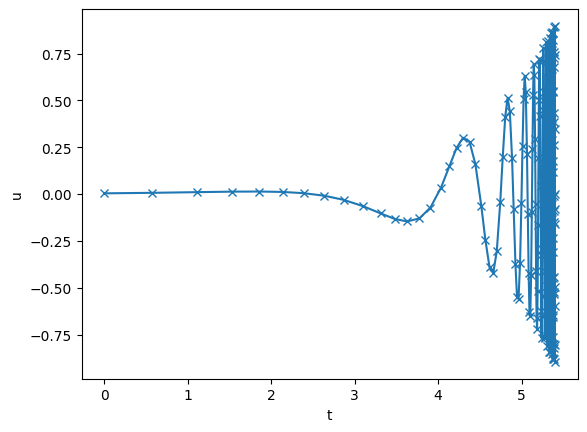

In [3]:
def rhs_q1(t, y):
    return np.array(
        [
            (12 * np.pi / (11 - 2 * t) ** 2)
            * np.cos(6 * np.pi / (11 - 2 * t))
            * np.exp(-(11 - 2 * t) / 2)
            + y
        ]
    )


def y_exact(t):
    return np.sin(6 * np.pi / (11 - 2 * t)) * np.exp(-(11 - 2 * t) / 2)


y0 = np.array([np.sin(6 * np.pi / 11) * np.exp(-11 / 2)])

y, t = ivp_adaptive.solve_to_adaptive(
    rhs_q1, y0, (0, 5.4), "dopri45", r_tol=1e-6, a_tol=1e-7
)

fig, ax = plt.subplots()
ax.plot(t, y[0, :], "x-")
ax.set_xlabel("t")
ax.set_ylabel("u")

As expected we see the method takes big steps when the solution is changing slowly and small steps when there are fast changes. We can verify this by plotting the step size over time.

Text(0, 0.5, 'Step Size')

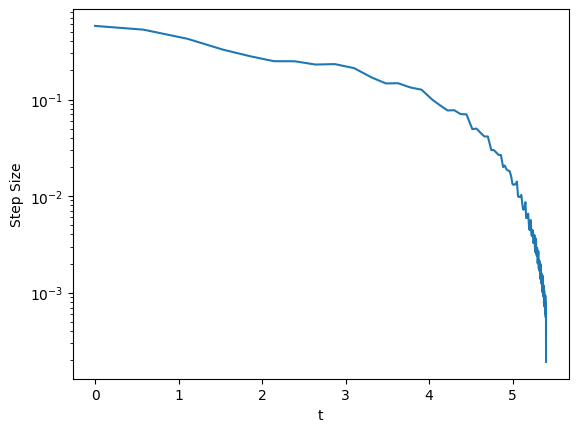

In [4]:
fig, ax = plt.subplots()
ax.plot(t[:-1], np.diff(t))
ax.set_yscale("log")
ax.set_xlabel("t")
ax.set_ylabel("Step Size")

Next we will check the error in the solution.

Text(0, 0.5, 'Error')

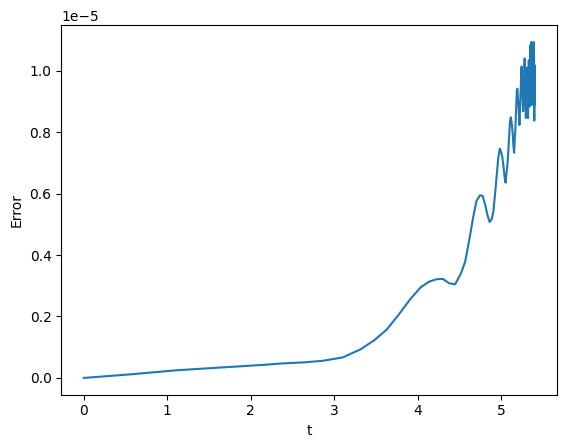

In [5]:
fig, ax = plt.subplots()
ax.plot(t, np.abs(y[0, :] - y_exact(t)))
ax.set_xlabel("t")
ax.set_ylabel("Error")

Here we see that the error statisfies our precribe tolerance.

# Question 2

First we implement a function for linear multistep methods.

In [6]:
from pna.ivp_multistep import solve_to_multistep

%psource solve_to_multistep

def solve_to_multistep(f, y0, t_span, dt, method, initial_method):
    """Solves ODE using a linear multistep method.

    Parameters
    ----------
    f : Callable
        ODE to solve. Must have signature f(t, y) -> array_like
    y0 : np.ndarray
        Initial condition
    t_span : tuple[float, float]
        Time span to solve over
    dt : float
        Step size to use
    method : str
        method to use. Options are "AB" for (explicit) Adams Bashforth schemes
        and "AM" for (implicit) Adams Moulton schemes
    initial_method : str
        Method to use to start the method. Options are "euler", "huen", "rk4".

    Returns
    -------
    y
        Solution to f
    t
        Time corresponding to solution y
    """
    num_initial = 3 if method == "AB" else 2
    # check we aren't going to over shoot in the setup
    if t_span[0] + num_initial * dt < t_span[1]:
        t_span_initial = (t_span[0], t_span[0] + num_initial * dt)
    else:
        t_span_initial = t_span

Text(0, 0.5, 'u')

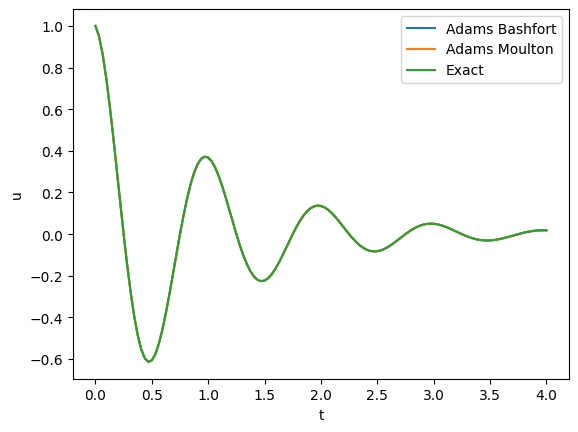

In [7]:
def rhs(t, u):
    return np.array(
        [
            u * (1 - np.exp(2 * t) * u**2)
            - np.exp(-t)
            * (
                2 * np.cos(2 * np.pi * t)
                - np.cos(2 * np.pi * t) ** 3
                + 2 * np.pi * np.sin(2 * np.pi * t)
            )
        ]
    )


def u_exact(t):
    return np.exp(-t) * np.cos(2 * np.pi * t)


dt = 1 / 32
u0 = np.array([1])
t_span = (0, 4)

y_AB, t_AB = solve_to_multistep(rhs, u0, t_span, dt, "AB", "rk4")
y_AM, t_AM = solve_to_multistep(rhs, u0, t_span, dt, "AM", "rk4")

fig, ax = plt.subplots()
ax.plot(t_AB, y_AB, label="Adams Bashfort")
ax.plot(t_AM, y_AM, label="Adams Moulton")
ax.plot(t_AB, u_exact(t_AB), label="Exact")
ax.legend()
ax.set_xlabel("t")
ax.set_ylabel("u")

Here we see that both methods give qualitively the right solution.

# Question 3

In [8]:
from collections import defaultdict

errors = defaultdict(list)

t_span = (0, 1)
y0 = np.array([np.sin(6 * np.pi / 11) * np.exp(-11 / 2)])
dts = np.logspace(-1, -10, base=2, num=10)

for dt in dts:
    for method in ["AB", "AM"]:
        for initial_method in ["euler", "rk4"]:
            y, t = solve_to_multistep(rhs_q1, y0, t_span, dt, method, initial_method)
            error = np.abs(y[-1, :] - y_exact(t[-1]))
            errors[f"{method},{initial_method}"].append(error)

/home/jakeb/development/practical_numerical_analysis/src/pna/ivp_multistep.py:41: UserWarning: With specified time step problem is solved entirely in setup
  warnings.warn("With specified time step problem is solved entirely in setup")


Text(0, 0.5, 'Error')

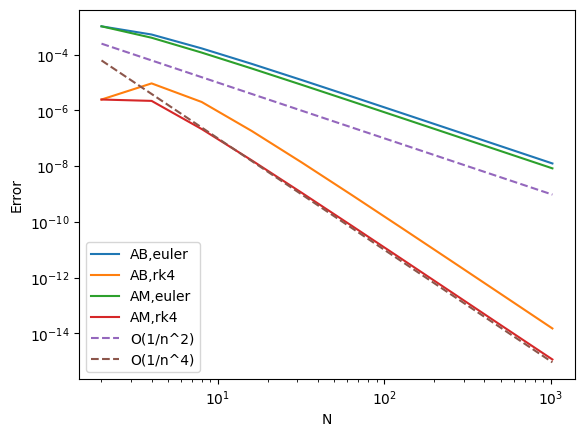

In [9]:
fig, ax = plt.subplots()
for method, error in errors.items():
    ax.loglog(dts ** (-1), error, label=method)
ax.loglog(dts ** (-1), 1e-3 * dts ** (2), "--", label="O(1/n^2)")
ax.loglog(dts ** (-1), 1e-3 * dts ** (4), "--", label="O(1/n^4)")

ax.legend()
ax.set_xlabel("N")
ax.set_ylabel("Error")

Here we see that both methods achieve 4th order converges when started with a fourth order method but only second order converges when started with a first order method.

# Question 4

In [10]:
from pna.finite_diff import theta_method

%psource theta_method

def theta_method(u0, dx, dt, steps, theta, left_bc, right_bc):
    """Solves the diffusion equation using the theta method.

    Parameters
    ----------
    u0 : np.ndarray
        Initial conditions
    dx : float
        spatial step
    dt : float
        time step
    steps : int
        Number of steps to take
    theta : float
        Controls interpolation between implicit and explicit euler, must be in [0,1]
    left_bc : Callable
        Function for left BC
    right_bc : Callable
        Function for the right BC

    Returns
    -------
    u
        Array of solution
    t
        Times solution is given at
    """
    N = len(u0) - 2
    u = np.empty((steps + 1, N))
    u[0, :] = u0[1:-1]
    t = [0]

    weights = [1, -2, 1]
    offsets = [-1, 0, 1]
    diags = [weights[i] * np.ones(N - abs(offset)) for i, offset in enumerate(offsets)]
    A = scipy.sparse.diags(diags, offsets, format="csr")
    b = np.zeros_like(u0[1:-1])
    I = scipy.sparse.eye(N)
    C = dt / dx**2

In [11]:
def exact(x, t):
    return np.exp(-((3 * np.pi / 2) ** 2) * t) * (
        np.sin(3 * np.pi * x / 2) - (3 * np.pi / 2) * np.cos(3 * np.pi * x / 2)
    )


errors = defaultdict(list)
Ns = np.array([32, 64, 128, 256])
thetas = [0, 0.5, 1]

for theta in thetas:
    for N in Ns:
        x = np.linspace(0, 1, num=N)
        dx = np.diff(x)[0]
        dt = 0.5 * dx**2
        u0 = np.sin(3 * np.pi * x / 2) - (3 * np.pi / 2) * np.cos(3 * np.pi * x / 2)
        u, t = theta_method(
            u0,
            dx,
            dt,
            np.ceil(0.25 / dt).astype(int),
            theta,
            lambda t: (-3 * np.pi / 2) * np.exp(-((3 * np.pi / 2) ** 2) * t),
            lambda t: -np.exp(-((3 * np.pi / 2) ** 2) * t),
        )

        errors[theta].append(np.linalg.norm(u[-1, :] - exact(x[1:-1], t[-1]), np.inf))

Text(0, 0.5, 'Error')

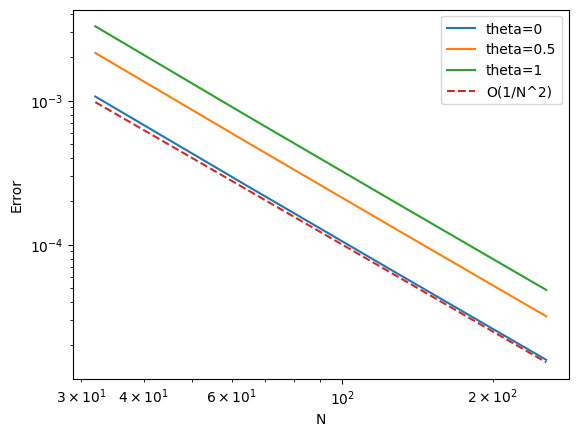

In [12]:
fig, ax = plt.subplots()
for theta in thetas:
    ax.loglog(Ns, errors[theta], label=f"{theta=}")
ax.loglog(Ns, (1 / Ns) ** 2, "--", label=f"O(1/N^2)")
ax.legend()
ax.set_xlabel("N")
ax.set_ylabel("Error")

Here we see, as expected, all of the methods are second order in space.

# Question 5

In [13]:
errors = defaultdict(list)
Ms = np.array([32, 64, 128, 256])
thetas = [0, 0.5, 1]
N = 512
x = np.linspace(0, 1, num=N)
dx = np.diff(x)[0]
u0 = np.sin(3 * np.pi * x / 2) - (3 * np.pi / 2) * np.cos(3 * np.pi * x / 2)
for theta in thetas:
    for M in Ms:
        dt = 0.25 / M
        u, t = theta_method(
            u0,
            dx,
            dt,
            M,
            theta,
            lambda t: (-3 * np.pi / 2) * np.exp(-((3 * np.pi / 2) ** 2) * t),
            lambda t: -np.exp(-((3 * np.pi / 2) ** 2) * t),
        )

        errors[theta].append(np.linalg.norm(u[-1, :] - exact(x[1:-1], t[-1]), np.inf))

Text(0, 0.5, 'Error')

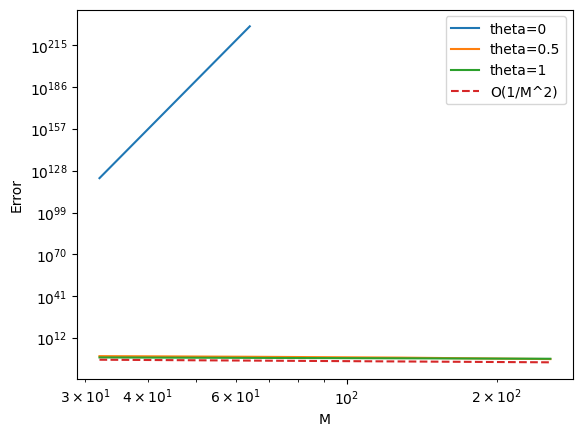

In [14]:
fig, ax = plt.subplots()
for theta in thetas:
    ax.loglog(Ms, errors[theta], label=f"{theta=}")
ax.loglog(Ms, (1 / Ms) ** 2, "--", label=f"O(1/M^2)")
ax.legend()
ax.set_xlabel("M")
ax.set_ylabel("Error")

Here we see that explicit Euler is unstable which is expected as

In [15]:
(0.25 / Ms) / dx**2

array([2040.0078125 , 1020.00390625,  510.00195313,  255.00097656])

which is considerably greater that the required bound of 0.5, we can repeat the plot again without explicit euler so we can actually see the others

Text(0, 0.5, 'Error')

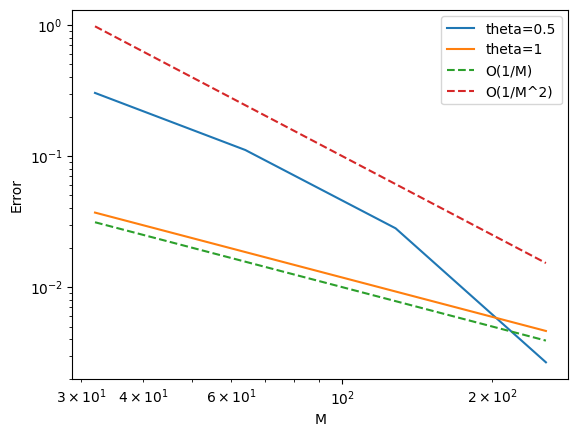

In [16]:
fig, ax = plt.subplots()
for theta in thetas[1:]:
    ax.loglog(Ms, errors[theta], label=f"{theta=}")
ax.loglog(Ms, (1 / Ms), "--", label=f"O(1/M)")
ax.loglog(Ms, 1e3 * (1 / Ms) ** 2, "--", label=f"O(1/M^2)")
ax.legend()
ax.set_xlabel("M")
ax.set_ylabel("Error")

Here we see the expected first and second order in time convergence for implicit Euler and CN respectively.

In [17]:
from time import perf_counter

N = M = 400
dt = 0.25 / M

x = np.linspace(0, 1, num=N)
dx = np.diff(x)[0]
u0 = np.sin(3 * np.pi * x / 2) - (3 * np.pi / 2) * np.cos(3 * np.pi * x / 2)

tic = perf_counter()
u, t = theta_method(
    u0,
    dx,
    dt,
    M,
    theta,
    lambda t: (-3 * np.pi / 2) * np.exp(-((3 * np.pi / 2) ** 2) * t),
    lambda t: -np.exp(-((3 * np.pi / 2) ** 2) * t),
)
toc = perf_counter()
error = np.linalg.norm(u[-1, :] - exact(x[1:-1], t[-1]))
print(f"{M=}, {N=}, {(toc - tic)=}, {error=}")

dt = 0.5 * dt**2

tic = perf_counter()
u, t = theta_method(
    u0,
    dx,
    dt,
    M,
    theta,
    lambda t: (-3 * np.pi / 2) * np.exp(-((3 * np.pi / 2) ** 2) * t),
    lambda t: -np.exp(-((3 * np.pi / 2) ** 2) * t),
)
toc = perf_counter()
error = np.linalg.norm(u[-1, :] - exact(x[1:-1], t[-1]))
print(f"{M=}, {N=}, {(toc - tic)=}, {error=}")

M=400, N=400, (toc - tic)=0.10941844999979367, error=0.04163322803765732
M=400, N=400, (toc - tic)=0.10798195500137808, error=1.5372409258209596e-06


We see that careful choice of the timestep can mean that for approximately the same run time we get a much more accurate solution. Just because the scheme is stable doesn't mean we shouldn't choose the stepsizes carefully.